In [12]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import multiprocessing
import math
import csv

In [13]:
path = "../data/128_files/"

In [14]:
def get_total_size(path, n_files):
    filenames = sorted(os.listdir(path))[:n_files]
    total_size = sum([os.path.getsize(path + filename) for filename in filenames])
    return total_size / (2**30)

In [15]:
def get_total_entries(path, n_files):
    filenames = sorted(os.listdir(path))[:n_files]
    total_entries = sum([uproot.open(path + filename + ":rootuple/CandidateTree").num_entries for filename in filenames])
    return total_entries

In [16]:
def col_average(data):
    n_rows = len(data)
    n_cols = len(data[0])
    return [sum([data[i][j] for i in range(1, n_rows)]) / (n_rows - 1) for j in range(n_cols)]

In [17]:
def col_standard_deviation(data):
    n_rows = len(data)
    n_cols = len(data[0])
    mean = col_average(data)
    return [(sum([(data[i][j] - mean[j])**2 for i in range(1, n_rows)]) / (n_rows - 1))**0.5 for j in range(n_cols)]

In [18]:
def read_part_of_data(files, n_entries, index, result):
    data = []
    for i in range(len(files)):
        data.append(files[i].arrays("candidate_vMass", 
                              "(candidate_charge == 0)\
                              & (candidate_cosAlpha > 0.99)\
                              & (candidate_lxy / candidate_lxyErr > 3.0)\
                              & (candidate_vProb > 0.05)\
                              & (ditrack_mass > 1.014) & (ditrack_mass < 1.024)\
                              & (candidate_vMass > 5.33) & (candidate_vMass < 5.4)",
                              entry_start=n_entries[i] * index,
                              entry_stop=n_entries[i] * (index + 1),
                              array_cache=None,
                              library="np")["candidate_vMass"])
    result.append(np.concatenate(tuple(data)))

In [19]:
def runtime_measure_mp(path, n_files, n_processes):
    start = time.time()
    files = [uproot.open(path=path + filename + ":rootuple/CandidateTree", object_cache=None, array_cache=None) for filename in sorted(os.listdir(path))[:n_files]]
    n_entries = [math.ceil(file.num_entries / n_processes) for file in files]
    result = multiprocessing.Manager().list()
    processes = []
    for i in range(n_processes):
        p = multiprocessing.Process(target=read_part_of_data, args=[files, n_entries, i, result])
        p.start()
        processes.append(p)

    for p in processes:
        p.join()
    
    np.concatenate(tuple(result))
    
    return time.time() - start

In [20]:
def partition_helper(slice_entries, file_entries, file_curr, entry_curr):
    if slice_entries <= file_entries[file_curr] - entry_curr:
        return [file_curr, slice_entries + entry_curr]
    elif file_curr == len(file_entries) - 1:
        return [file_curr, file_entries[-1]]
    else:
        return partition_helper(slice_entries - file_entries[file_curr] + entry_curr, file_entries, file_curr + 1, 0)

def partition(files, n_processes):
    file_entries = [file.num_entries for file in files]
    slice_entries = math.ceil(sum(file_entries) / n_processes)
    slices = []
    file_start = 0
    entry_start = 0
    for i in range(n_processes):
        slices.append([file_start, entry_start] + partition_helper(slice_entries, file_entries, file_start, entry_start))
        file_start = slices[-1][-2]
        entry_start = slices[-1][-1]
    return slices

In [21]:
partition_helper(1000, a, 0, 0)

NameError: name 'a' is not defined

In [410]:
partition_helper(1000, a, 0, 1000)

[1, 1000]

In [22]:
def read_part_of_data_test(files, partitions, index, result):
    data = []
    for i in range(partitions[index][0], partitions[index][2] + 1):
        data.append(files[i].arrays("candidate_vMass", 
                              "(candidate_charge == 0)\
                              & (candidate_cosAlpha > 0.99)\
                              & (candidate_lxy / candidate_lxyErr > 3.0)\
                              & (candidate_vProb > 0.05)\
                              & (ditrack_mass > 1.014) & (ditrack_mass < 1.024)\
                              & (candidate_vMass > 5.33) & (candidate_vMass < 5.4)",
                              entry_start=partitions[index][1] if i == partitions[index][0] else None,
                              entry_stop=partitions[index][3] if i == partitions[index][2] else None,
                              array_cache=None,
                              library="np")["candidate_vMass"])
    result.append(np.concatenate(tuple(data)))

In [23]:
def runtime_measure_mp_test(path, n_files, n_processes):
    start = time.time()
    files = [uproot.open(path=path + filename + ":rootuple/CandidateTree", object_cache=None, array_cache=None) for filename in sorted(os.listdir(path))[:n_files]]
    partitions = partition(files, n_processes)
    result = multiprocessing.Manager().list()
    processes = []
    for i in range(n_processes):
        p = multiprocessing.Process(target=read_part_of_data_test, args=[files, partitions, i, result])
        p.start()
        processes.append(p)

    for p in processes:
        p.join()
    
    np.concatenate(tuple(result))
    
    return time.time() - start

In [24]:
runtime_measure_mp_test(path, 8, 32)

Process Process-22:
Process Process-17:
Process Process-2:
Exception ignored in: <function _releaseLock at 0x7f45c98371f0>
Traceback (most recent call last):
  File "/lustrehome/hdhoang2001/.conda/envs/new/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
Process Process-15:
Process Process-14:
Process Process-16:
Process Process-3:
Process Process-5:
Process Process-4:
Process Process-11:
Process Process-13:
Process Process-7:
Process Process-8:
Process Process-10:
Process Process-12:
Process Process-6:
Process Process-9:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-25:
Traceback (most recent call last):
  File "/l

  File "/lustrehome/hdhoang2001/.conda/envs/new/lib/python3.9/site-packages/uproot/model.py", line 806, in read
    self.read_members(chunk, cursor, context, file)
  File "/tmp/ipykernel_30611/1434688332.py", line 4, in read_part_of_data_test
    data.append(files[i].arrays("candidate_vMass",
  File "/lustrehome/hdhoang2001/.conda/envs/new/lib/python3.9/site-packages/uproot/compression.py", line 93, in decompress
    return zlib.decompress(data)
  File "/lustrehome/hdhoang2001/.conda/envs/new/lib/python3.9/site-packages/uproot/models/TBasket.py", line 283, in read_members
    uncompressed = uproot.compression.decompress(
  File "/lustrehome/hdhoang2001/.conda/envs/new/lib/python3.9/site-packages/uproot/behaviors/TBranch.py", line 3416, in chunk_to_basket
    basket = uproot.models.TBasket.Model_TBasket.read(
  File "/lustrehome/hdhoang2001/.conda/envs/new/lib/python3.9/site-packages/uproot/behaviors/TBranch.py", line 1257, in arrays
    _ranges_or_baskets_to_arrays(
KeyboardInterrupt
 

In [343]:
runtime_measure_mp(path, 8, 32)

3.387380361557007

In [25]:
def runtime_vs_size_mp(path, n_processes, max_files, step, n_loops, target_dir):
    result_path = ("runtime_tests_uproot/%s/runtime_vs_size_mp_%d_%d_%d_%d.csv" % (target_dir, n_processes, max_files, step, n_loops))
    x = [get_total_size(path, a) for a in range(step, max_files + step, step)]
    with open(result_path, "w+", newline="") as f:
        csv.writer(f).writerow(x)
    for n in range(n_loops):
        y = [runtime_measure_mp(path, i, n_processes) for i in range(step, max_files + step, step)]
        with open(result_path, "a+", newline="") as f:
            csv.writer(f).writerow(y)

In [26]:
def runtime_vs_size_plot_mp(path, n_processes, max_files, step, n_loops, target_dir):
    if not os.path.exists("runtime_tests_uproot/%s" % (target_dir)):
        os.mkdir("runtime_tests_uproot/%s" % (target_dir))
    if not os.path.exists("figures/uproot/%s" % (target_dir)):
        os.mkdir("figures/uproot/%s" % (target_dir))
    result_path = ("runtime_tests_uproot/%s/runtime_vs_size_mp_%d_%d_%d_%d.csv" % (target_dir, n_processes, max_files, step, n_loops))
    if not os.path.exists(result_path):
        runtime_vs_size_mp(path, n_processes, max_files, step, n_loops, target_dir)
    with open(result_path, "r") as f:
        data = [[float(a) for a in row] for row in csv.reader(f)]
        plt.figure(figsize = (20, 8))
        plt.title('Runtime vs Size (%d processes)' % (n_processes))
        plt.xlabel('Size (GB)')
        plt.ylabel('Runtime (s)')
        #plt.scatter(data[0], col_average(data))
        #for r in range(1, len(data)):
            #plt.scatter(data[0], data[r])
        plt.errorbar(data[0], col_average(data[1:]), yerr=col_standard_deviation(data[1:]), fmt="o", ecolor="orange")
        for i in range(len(data[0])): 
            plt.annotate("%.2f(%d)" % (round(col_average(data[1:])[i], 2), (i + 1) * step), (data[0][i], col_average(data[1:])[i]))
        plt.savefig('figures/uproot/%s/runtime_vs_size_mp_%d_%d_%d_%d.png' % (target_dir, n_processes, max_files, step, n_loops), bbox_inches='tight')

In [27]:
def runtime_vs_processes(path, n_files, max_processes, step, n_loops, target_dir):
    parent_dir = path.split('/')[-2]
    result_path = ("runtime_tests_uproot/%s/runtime_vs_processes_%d_%d_%d_%d.csv" % (target_dir, n_files, max_processes, step, n_loops))
    x = [a for a in range(step, max_processes + step, step)]
    with open(result_path, "w+", newline="") as f:
        csv.writer(f).writerow(x)
    for n in range(n_loops):
        y = [runtime_measure_mp(path, n_files, i) for i in range(step, max_processes + step, step)]
        with open(result_path, "a+", newline="") as f:
            csv.writer(f).writerow(y)

In [28]:
def runtime_vs_processes_plot(path, n_files, max_processes, step, n_loops, target_dir):
    parent_dir = path.split('/')[-2]
    if not os.path.exists("runtime_tests_uproot/%s" % (target_dir)):
        os.mkdir("runtime_tests_uproot/%s" % (target_dir))
    if not os.path.exists("figures/uproot/%s" % (target_dir)):
        os.mkdir("figures/uproot/%s" % (target_dir))
    result_path = ("runtime_tests_uproot/%s/runtime_vs_processes_%d_%d_%d_%d.csv" % (target_dir, n_files, max_processes, step, n_loops))
    if not os.path.exists(result_path):
        runtime_vs_processes(path, n_files, max_processes, step, n_loops, target_dir)
    with open(result_path, "r") as f:
        data = [[float(a) for a in row] for row in csv.reader(f)]
        plt.figure(figsize = (20, 8))
        plt.title('Runtime vs Processes (%d files, %.2f GB)' % (n_files, get_total_size(path, n_files)))
        plt.xlabel('Processes')
        plt.ylabel('Runtime (s)')
        #plt.scatter(data[0], col_average(data))
        #for r in range(1, len(data)):
            #plt.scatter(data[0], data[r])
        plt.xticks(range(step, max_processes + 1, step))
        plt.errorbar(data[0], col_average(data[:]), yerr=col_standard_deviation(data[:]), fmt="o", ecolor="orange")
        for i in range(len(data[0])): 
            plt.annotate(round(col_average(data[:])[i], 2), (data[0][i], col_average(data[:])[i]))
        plt.savefig('figures/uproot/%s/runtime_vs_processes_%d_%d_%d_%d.png' % (target_dir, n_files, max_processes, step, n_loops), bbox_inches='tight')

In [29]:
# runtime_vs_processes_plot(path, 60, 60, 4, 10, "merged")

In [30]:
# runtime_vs_processes_plot(path, 60, 60, 4, 10, "merged_test")

In [31]:
# runtime_vs_processes_plot(path, 80, 80, 5, 10, "merged")

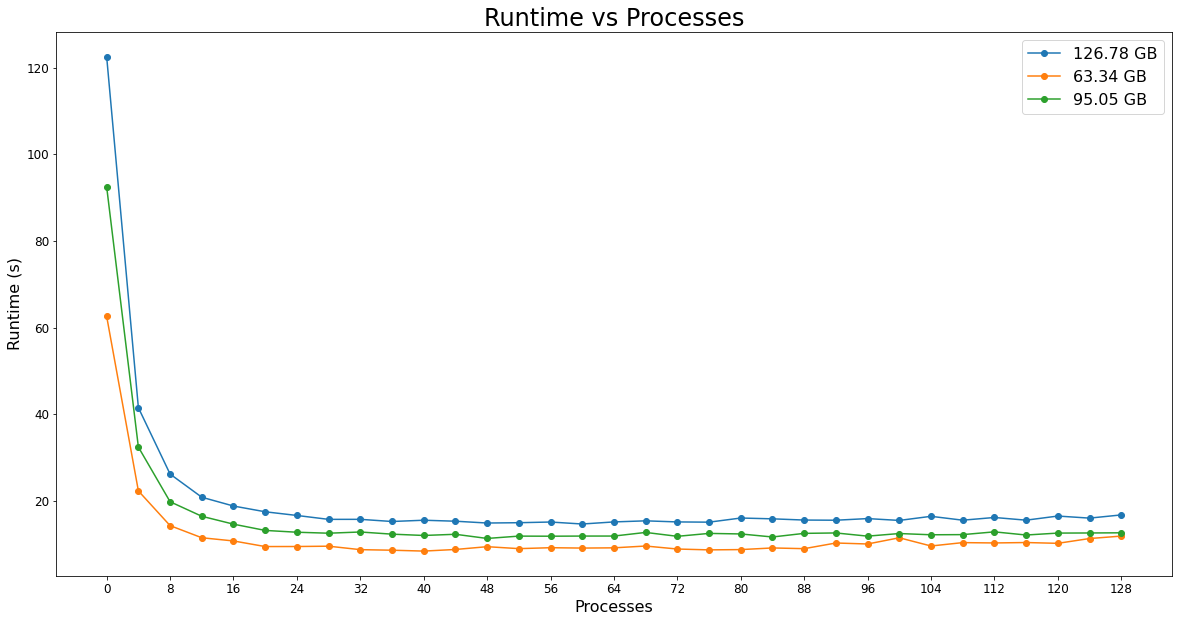

In [35]:
data = []
result_path = "runtime_tests_uproot/128_files/"
for file in sorted(os.listdir(result_path)):
    if file.endswith(".csv") and "runtime_vs_processes" in file:
        with open(result_path + file, "r") as f:
            data.append([[float(a) for a in row] for row in csv.reader(f)])
        
plt.figure(figsize = (20, 10))
plt.title('Runtime vs Processes', fontsize=24)
plt.xlabel('Processes', fontsize=16)
plt.ylabel('Runtime (s)', fontsize=16)
plt.xticks(range(0, 129, 8), fontsize=12)
plt.yticks(fontsize=12)
plt.plot(data[0][0], col_average(data[0][1:]), marker="o", label="%.2f GB" % (get_total_size(path, 128)))
plt.plot(data[1][0], col_average(data[1][1:]), marker="o", label="%.2f GB" % (get_total_size(path, 64)))
plt.plot(data[2][0], col_average(data[2][1:]), marker="o", label="%.2f GB" % (get_total_size(path, 96)))
plt.legend(prop={'size': 16})
plt.show()


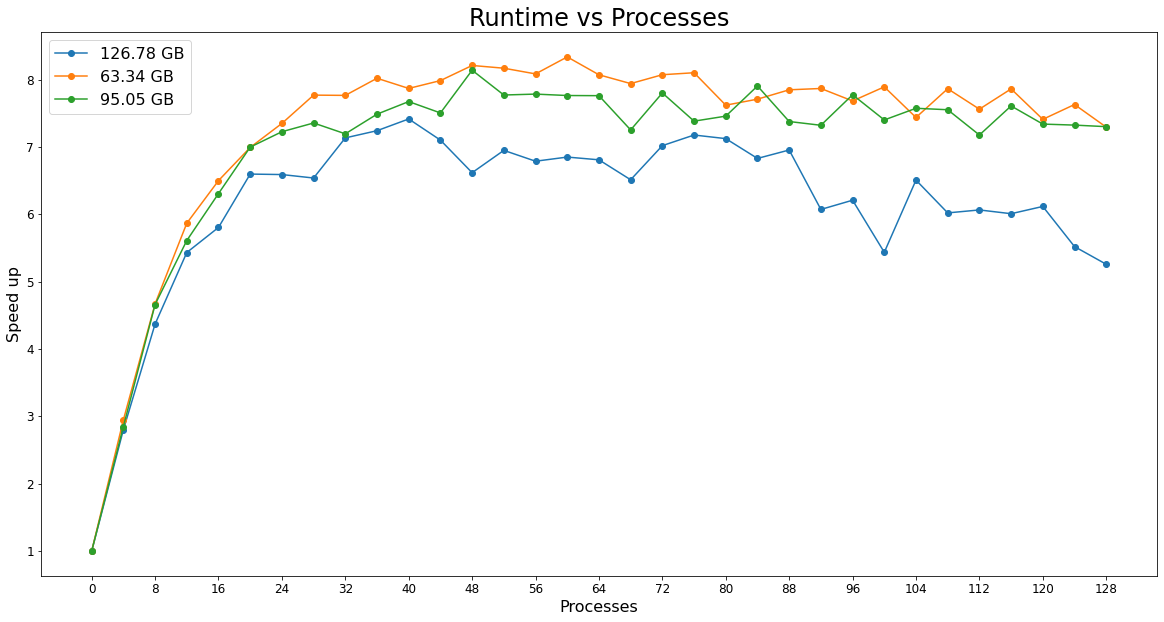

In [34]:
data = []
result_path = "runtime_tests_uproot/128_files/"
for file in os.listdir(result_path):
    if file.endswith(".csv") and "runtime_vs_processes" in file:
        with open(result_path + file, "r") as f:
            data.append([[float(a) for a in row] for row in csv.reader(f)])
        
plt.figure(figsize = (20, 10))
plt.title('Runtime vs Processes', fontsize=24)
plt.xlabel('Processes', fontsize=16)
plt.ylabel('Speed up', fontsize=16)
plt.xticks(range(0, 129, 8), fontsize=12)
plt.yticks(fontsize=12)
plt.plot(data[0][0], [col_average(data[0][1:])[0] / n for n in col_average(data[0][1:])], marker="o", label="%.2f GB" % (get_total_size(path, 128)))
plt.plot(data[1][0], [col_average(data[1][1:])[0] / n for n in col_average(data[1][1:])], marker="o", label="%.2f GB" % (get_total_size(path, 64)))
plt.plot(data[2][0], [col_average(data[2][1:])[0] / n for n in col_average(data[2][1:])], marker="o", label="%.2f GB" % (get_total_size(path, 96)))
plt.legend(prop={'size': 16})
plt.show()